# Detector simulation
In this notebook we load a track dataset generated by `edep-sim` and we calculate the ADC counts corresponding to each pixel. The result is exported to a HDF5 file.

In [1]:
import numpy as np
## Ionization calculations
K = 0.307075 # MeV cm^2 / mol
Z = 18
A = 39.948 # [https://pdg.lbl.gov/2020/AtomicNuclearProperties/HTML/liquid_argon.html]
I = 188.0e-6 # MeV [https://physics.nist.gov/PhysRefData/XrayMassCoef/tab1.html]
rho = 1.396 # g/cm^3
w = 23.6e-6 # MeV/ionization
r = 0.6980 # recombination factor
m_muon = 105.7 # MeV/c^2
m_e = 0.511
def landau_csi(x,p,m=m_muon):
    ''' x is ionization length [cm], p is particle momentum [MeV/c], m is particle mass [MeV/c^2] '''
    beta = p / np.sqrt(p**2 + m**2)
    return (K/2) * (Z/A) * (x*rho/beta**2)
def delta(betagamma):
    ''' for values: [https://pdg.lbl.gov/2020/AtomicNuclearProperties/MUE/muE_liquid_argon.pdf] '''
#     x0 = 1.7635 # https://lar.bnl.gov/properties/pass.html ref [1]
#     x1 = 4.485
#     Cm = 11.9480
#     a = 0.19714
#     k = 2.9618
    x0 = 0.2000 # [pdg]
    x1 = 3.000 # [pdg]
    Cm = 5.2146 # [pdg]
    a = 0.19559 # [pdg]
    k = 3.000 # [pdg]
    x = np.log10(betagamma)
    if x < x0:
        return 0.
    elif x >= x0 and x < x1:
        return 2*np.log(10)*x - Cm + a*(x1-x)**k
    return 2*np.log(10)*x - Cm
def landau_mvp(x,p,m=m_muon):
    e = np.sqrt(p**2 + m**2)
    beta = p / e
    gamma = e / m
    csi = landau_csi(x,p,m)
    c0 = np.log(2 * m_e * beta**2 * gamma**2 / I)
    c1 = np.log(csi/I)
    return  csi * (c0 + c1 + 0.200 - beta**2 - delta(beta*gamma))
x = 1 # cm
p = 5e3 # MeV/c
std_2_fwhm = 2*np.sqrt(2*np.log(2)) # convert btw FWHM and sigma for a gaussian
# print('\n~~~ INFO ~~~')
# print('using track length of {}cm'.format(x))
# print('using muon momentum of {}MeV'.format(p))
for x in np.linspace(0,2,10):
#     print('\n~~~ PEAK ~~~')
#     print('expected {:0.03f}MeV/cm [mpv]'.format(landau_mvp(x,p)/x))
    expected_peak = (landau_mvp(x,p) / w) * r / x / 1e4 # ke/mm
#     print('expected {:0.03f}ke/mm [mpv]'.format(expected_peak))
    meas_peak = 6.2 # ke/mm
#     print('meas {:0.03f}ke/mm [mpv]'.format(meas_peak))
    diff = meas_peak/expected_peak - 1.
#     print('off by {:0.03}%'.format(diff*100.))
#     print('\n~~~ WIDTH ~~~')
    fwhm = (4 * landau_csi(x,p) / w) * r / x # e/cm
    expected_sigma = fwhm / 1e4 / std_2_fwhm # ke/mm
#     print('expected {:0.06f}ke/mm [std]'.format(expected_sigma))
meas_sigma = .530 # ke/mm
# print('meas {:0.03f}ke/mm [std]'.format(meas_sigma))
diff_sigma = np.sqrt(meas_sigma**2 - expected_sigma**2)
# print('diff {:0.03f}ke/mm [std]'.format(diff_sigma))
pixel_pitch = 4.434 # mm
noise = 1. # ke
noise_sigma = (noise/pixel_pitch) / np.sqrt(x/pixel_pitch)
# print('expected noise {:0.03f}ke/mm [std]'.format(noise_sigma))
diff_sigma = np.sign(diff_sigma**2 - noise_sigma**2)*np.sqrt(np.abs(diff_sigma**2 - noise_sigma**2))
# print('remaining {:0.03f}ke/mm [std]'.format(diff_sigma))

/global/u1/s/soleti/.conda/envs/numbaenv/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in log
/global/u1/s/soleti/.conda/envs/numbaenv/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars
/global/u1/s/soleti/.conda/envs/numbaenv/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in double_scalars


In [2]:
p = 0.51

In [3]:
ratios = []
fwhms=[]
for x in np.linspace(0.1,2,10):
#     print('\n~~~ PEAK ~~~')
    expected_peak = (landau_mvp(x,p) / w) * r / x / 1e4 # ke/mm
#     print('expected {:0.03f}ke/mm [mpv]'.format(expected_peak))
#     print('\n~~~ WIDTH ~~~')
    fwhm = (4 * landau_csi(x,p) / w) * r / x # e/cm
    fwhms.append(fwhm)
    expected_sigma = fwhm / 1e4 / std_2_fwhm # ke/mm
#     print('expected {:0.06f}ke/mm [std]'.format(expected_sigma))
    ratios.append(expected_sigma/expected_peak)

Text(0.5, 0, 'dx [cm]')

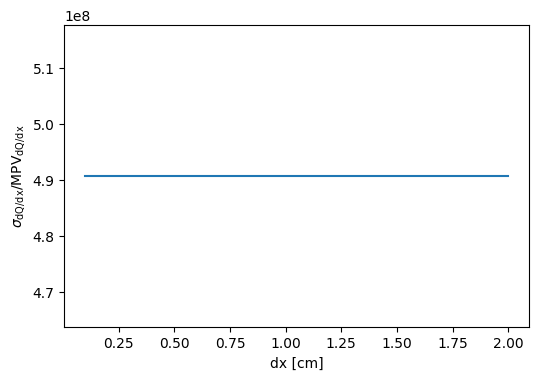

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
fig,ax = plt.subplots(1,1)
ax.plot(np.linspace(0.1,2,10),fwhms)
ax.set_ylabel(r"$\sigma_{\mathrm{dQ/dx}}/\mathrm{MPV}_{\mathrm{dQ/dx}}$")
ax.set_xlabel("dx [cm]")

Text(0.5, 0, 'dx [cm]')

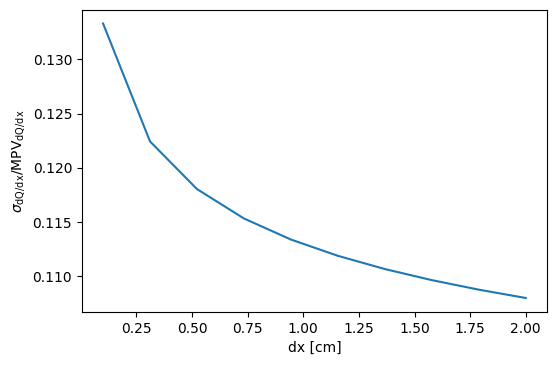

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
fig,ax = plt.subplots(1,1)
ax.plot(np.linspace(0.1,2,10),ratios)
ax.set_ylabel(r"$\sigma_{\mathrm{dQ/dx}}/\mathrm{MPV}_{\mathrm{dQ/dx}}$")
ax.set_xlabel("dx [cm]")

In [1]:
# This is need so you can import larndsim without doing python setup.py install
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [2]:
from math import ceil
from time import time

import matplotlib.pyplot as plt
from matplotlib import cm, colors
import mpl_toolkits.mplot3d.art3d as art3d

import numpy as np
import cupy as cp
import fire
import h5py

from numba import cuda
from numba.cuda.random import create_xoroshiro128p_states

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100


from tqdm.notebook import tqdm

In [3]:
from larndsim import consts
import importlib
importlib.reload(consts)
consts.load_detector_properties("../larndsim/detector_properties/module0.yaml","../larndsim/pixel_layouts/multi_tile_layout-2.2.16.yaml")

from larndsim import quenching, drifting, detsim, pixels_from_track, fee

In [4]:
phiangles = np.linspace(-80,80,4)
tanangles = np.linspace(10,80,4)


def xy_points(point, edges, tanangles, phiangles):

    x_starts = []
    x_ends = []
    y_starts = []
    y_ends = []
    z_starts = []
    z_ends = []

    for tanangle in tanangles:
        for phiangle in phiangles:
            dx2 = edges[0][1]-point[0]
            dy2 = np.tan(np.deg2rad(phiangle))*dx2

            if dy2+point[1] > edges[1][1]:
                dy2 = edges[1][1]-point[1]
                dx2 = dy2/np.tan(np.deg2rad(phiangle))
            elif dy2+point[1] < edges[1][0]:
                dy2 = edges[1][0]-point[1]
                dx2 = dy2/np.tan(np.deg2rad(phiangle))


            dx1 = point[0]-edges[0][0]
            dy1 = np.tan(np.deg2rad(phiangle))*dx1

            if point[1]-dy1 < edges[1][0]:
                dy1 = point[1]-edges[1][0]
                dx1 = dy1/np.tan(np.deg2rad(phiangle))
            elif point[1]-dy1 > edges[1][1]:
                dy1 = point[1]-edges[1][1]
                dx1 = dy1/np.tan(np.deg2rad(phiangle))

            z_starts.append(consts.tpc_borders[0][2][0]+1)
            x_start = point[0]-dx1
            x_end = point[0]+dx2
            x_starts.append(x_start)
            x_ends.append(x_end)

            y_start = point[1]-dy1
            y_end = point[1]+dy2
            y_starts.append(y_start)
            y_ends.append(y_end)
            
            xy = np.sqrt((dx1+dx2)**2+(dy1+dy2)**2)
            z_ends.append(consts.tpc_borders[0][2][0]+1+xy*np.tan(np.deg2rad(tanangle)))

    return x_starts, x_ends, y_starts, y_ends, z_starts, z_ends

In [5]:
angles = []
for tanangle in tanangles:
    for phiangle in phiangles:
        angles.append((tanangle,phiangle))

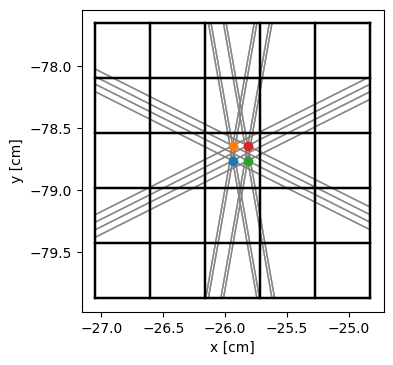

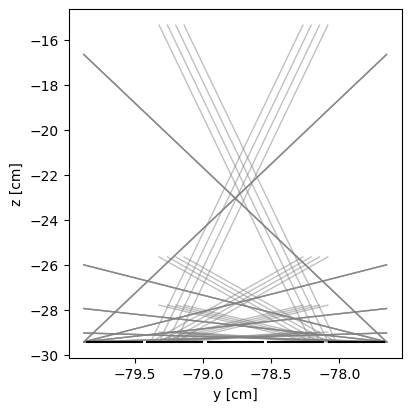

In [6]:
fig1,ax1 = plt.subplots(1,1)
fig2,ax2 = plt.subplots(1,1,figsize=(4,4),constrained_layout=True)


center = np.array(detsim.get_pixel_coordinates((11,11)))+consts.pixel_pitch/2
edges = np.array([[center[0]-consts.pixel_pitch*2.5, center[0]+consts.pixel_pitch*2.5],[center[1]-consts.pixel_pitch*2.5, center[1]+consts.pixel_pitch*2.5]])

offsets = []

for sx in np.linspace(0,consts.pixel_pitch/2-0.1,2):
    for sy in np.linspace(0,consts.pixel_pitch/2-0.1,2):
        point = np.copy(center)
        point[0] += sx
        point[1] += sy
        offsets.append((sx,sy))
        x_starts, x_ends, y_starts, y_ends, z_starts, z_ends = xy_points(point, edges, tanangles, phiangles)
    
        ax1.plot((x_starts,x_ends),(y_starts,y_ends),c='gray',lw=1,alpha=0.5)
        ax2.plot((y_starts,y_ends),(z_starts,z_ends),c='gray',lw=1,alpha=0.5)
        ax1.scatter(*point,zorder=999)
    
ax1.set_aspect('equal')

for iy in range(6):
    for ix in range(6):
        ax1.plot((edges[0][0]+ix*consts.pixel_pitch,edges[0][0]+ix*consts.pixel_pitch),(edges[1][0],edges[1][1]),c='k')
        ax1.plot((edges[0][0],edges[0][1]),(edges[1][0]+iy*consts.pixel_pitch,edges[1][0]+iy*consts.pixel_pitch),c='k')


for iy in range(5):
    ax2.plot((edges[1][0]+iy*consts.pixel_pitch+0.02,edges[1][0]+(iy+1)*consts.pixel_pitch-0.02),(z_starts[0],z_starts[0]),c='k')

        
ax1.set_xlabel("x [cm]")
ax1.set_ylabel("y [cm]")

ax2.set_xlabel("y [cm]")
ax2.set_ylabel("z [cm]")
ax1.set_aspect("equal")

fig1.savefig("pixels.pdf")
fig2.savefig("pixels_yz.pdf")

In [7]:
def intersection(xy1, xy2, xy3, xy4):
    d = (xy1[0] - xy2[0])*(xy3[1] - xy4[1]) - (xy1[1] - xy2[1])*(xy3[0] - xy4[0])
    x = (xy1[0]*xy2[1] - xy1[1]*xy2[0])*(xy3[0]-xy4[0]) - (xy1[0]-xy2[0])*(xy3[0]*xy4[1] - xy3[1]*xy4[0])
    y = (xy1[0]*xy2[1] - xy1[1]*xy2[0])*(xy3[1]-xy4[1]) - (xy1[1]-xy2[1])*(xy3[0]*xy4[1] - xy3[1]*xy4[0])
    return np.array((x,y)) / d

PIXEL_PITCH = consts.pixel_pitch

def clipping_length(start_xy, end_xy, x, y):
    intersections = np.array([
        intersection(start_xy, end_xy, cornerxy0, cornerxy1)
        for cornerxy0, cornerxy1 in (
            ((x-PIXEL_PITCH/2,y-PIXEL_PITCH/2), (x-PIXEL_PITCH/2, y+PIXEL_PITCH/2)), # LL->UL
            ((x-PIXEL_PITCH/2,y+PIXEL_PITCH/2), (x+PIXEL_PITCH/2, y+PIXEL_PITCH/2)), # UL->UR
            ((x+PIXEL_PITCH/2,y+PIXEL_PITCH/2), (x+PIXEL_PITCH/2, y-PIXEL_PITCH/2)), # UR->LR
            ((x+PIXEL_PITCH/2,y-PIXEL_PITCH/2), (x-PIXEL_PITCH/2, y-PIXEL_PITCH/2)), # LR->LL
        )
    ])
    d = np.linalg.norm(intersections - np.array([[x,y]]), axis=1)
    sort_idcs = np.argsort(d, axis=0) # get two closest points
    intersections = np.take_along_axis(intersections, np.broadcast_to(sort_idcs[:,np.newaxis,:], intersections.shape), axis=0)
    pix_start_xy = intersections[0]
    pix_end_xy = intersections[1]
    l = np.linalg.norm(pix_end_xy-pix_start_xy, axis=0)
    l *= (np.min(d, axis=0) < np.sqrt(2) * PIXEL_PITCH/2)
    l *= (x <= max(start_xy[0], end_xy[0])) & (x >= min(start_xy[0], end_xy[0])) & (y <= max(start_xy[1], end_xy[1])) & (y >= min(start_xy[1], end_xy[1]))
    
    return l, pix_start_xy, pix_end_xy

In [8]:
with h5py.File('module0_corsika.h5', 'r') as f:
    corsika_tracks = np.array(f['segments'])

tracks = np.zeros(len(x_starts)*4,dtype=corsika_tracks.dtype)
lengths = np.zeros(len(x_starts)*4)
c=0
for sx in np.linspace(0,consts.pixel_pitch/2-0.1,2):
    for sy in np.linspace(0,consts.pixel_pitch/2-0.1,2):
        point = np.copy(center)
        point[0] += sx
        point[1] += sy
        
        x_starts, x_ends, y_starts, y_ends, z_starts, z_ends = xy_points(point, edges, tanangles, phiangles)

        for i in range(len(x_starts)):
            tracks[c]['x_start'] = x_starts[i]
            tracks[c]['y_start'] = y_starts[i]
            tracks[c]['z_start'] = z_starts[i]

            tracks[c]['x_end'] = x_ends[i]
            tracks[c]['y_end'] = y_ends[i]
            tracks[c]['z_end'] = z_ends[i]
            l, _, _ = clipping_length([x_starts[i],y_starts[i]],[x_ends[i],y_ends[i]],np.array([center[0]]),np.array([center[1]]))
            lengths[c] = l[0]/np.cos(np.deg2rad(angles[i][0]))
            tracks[c]['x'] = (x_ends[i]+x_starts[i])/2
            tracks[c]['y'] = (y_ends[i]+y_starts[i])/2
            tracks[c]['z'] = (z_ends[i]+z_starts[i])/2

            tracks[c]['dx'] = np.sqrt((x_ends[i]-x_starts[i])**2+(y_ends[i]-y_starts[i])**2+(z_ends[i]-z_starts[i])**2)
            tracks[c]['dE'] = 2*tracks[i]['dx']
            tracks[c]['dEdx'] = 2

            tracks[c]['eventID'] = 0
            tracks[c]['trackID'] = i
            tracks[c]['pdgId'] = 13
            tracks[c]['t'] = 0
            tracks[c]['t_start'] = 0
            tracks[c]['t_end'] = 0
            c+=1

In [1]:
!pwd

/global/u1/s/soleti/larnd-sim/examples


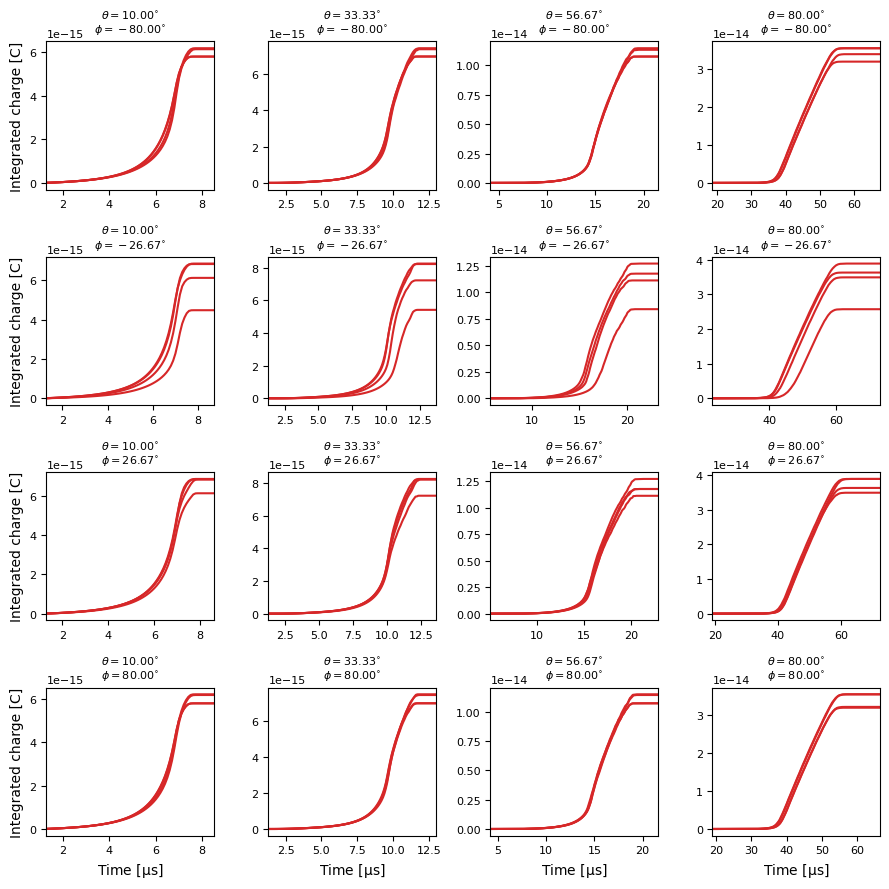

In [9]:
fig,ax = plt.subplots(4,4,tight_layout=True,figsize=(9,9))
response = cp.load('response.npy')
# print("OffsetX,OffsetY,Theta,Phi,dQdx_sim/dQdx_exp,Q_ADC/Q_full")
for i in tqdm(range(tracks.shape[0])):

    j = i % 16
    ax_x = j % 4
    ax_y = j // 4
    
    selected_tracks = tracks[i:i+1]
    TPB = 256
    BPG = ceil(selected_tracks.shape[0] / TPB)

    quenching.quench[BPG,TPB](selected_tracks, consts.birks)
    drifting.drift_lookup[BPG,TPB](selected_tracks)

    # Here we build a map between tracks and event IDs
    unique_eventIDs = np.unique(selected_tracks['eventID'])
    event_id_map = np.searchsorted(unique_eventIDs,selected_tracks['eventID'])

    longest_pix = ceil(max(selected_tracks["dx"])/consts.pixel_pitch)
    max_radius = ceil(max(selected_tracks["tran_diff"])*5/consts.pixel_pitch)

    MAX_PIXELS = int((longest_pix*4+6)*max_radius*1.5)
    MAX_ACTIVE_PIXELS = int(longest_pix*1.5)

    active_pixels = np.full((selected_tracks.shape[0], MAX_ACTIVE_PIXELS, 2), -1, dtype=np.int32)
    neighboring_pixels = np.full((selected_tracks.shape[0], MAX_PIXELS, 2), -1, dtype=np.int32)
    n_pixels_list = np.zeros(shape=(selected_tracks.shape[0]))
    TPB = 128
    BPG = ceil(selected_tracks.shape[0] / TPB)
    pixels_from_track.get_pixels[BPG,TPB](selected_tracks,
                                          active_pixels,
                                          neighboring_pixels,
                                          n_pixels_list,
                                          max_radius+1)
    
    shapes = neighboring_pixels.shape
    joined = neighboring_pixels.reshape(shapes[0]*shapes[1],2)
    unique_pix = np.unique(joined,axis=0)
    unique_pix = unique_pix[(unique_pix[:,0] != -1) & (unique_pix[:,1] != -1),:]
    
    max_length = cp.array([0])
    track_starts = cp.empty(selected_tracks.shape[0])
    threadsperblock = 128
    blockspergrid = ceil(selected_tracks.shape[0] / threadsperblock)
    detsim.time_intervals_lookup[blockspergrid,threadsperblock](track_starts, max_length,  event_id_map, selected_tracks)
    
    signals = cp.zeros((selected_tracks.shape[0],
                        neighboring_pixels.shape[1],
                        cp.asnumpy(max_length)[0]), dtype=np.float32)
    threadsperblock = (1,1,64)
    blockspergrid_x = ceil(signals.shape[0] / threadsperblock[0])
    blockspergrid_y = ceil(signals.shape[1] / threadsperblock[1])
    blockspergrid_z = ceil(signals.shape[2] / threadsperblock[2])
    blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)
    detsim.tracks_current_lookup[blockspergrid,threadsperblock](signals,
                                                         neighboring_pixels,
                                                         selected_tracks,
                                                         response)
    
    pixel_index_map = np.full((selected_tracks.shape[0], neighboring_pixels.shape[1]), -1)
    compare = neighboring_pixels[..., np.newaxis, :] == unique_pix
    indices = np.where(np.logical_and(compare[..., 0], compare[..., 1]))

    pixel_index_map[indices[0], indices[1]] = indices[2]

    blockspergrid_x = ceil(signals.shape[0] / threadsperblock[0])
    blockspergrid_y = ceil(signals.shape[1] / threadsperblock[1])
    blockspergrid_z = ceil(signals.shape[2] / threadsperblock[2])
    blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)
    pixels_signals = np.zeros((len(unique_pix), len(consts.time_ticks)))
    detsim.sum_pixel_signals[blockspergrid,threadsperblock](pixels_signals,
                                                            signals,
                                                            track_starts,
                                                            pixel_index_map)

    my_pix = np.where((unique_pix[:,0]==11) & (unique_pix[:,1] == 11))[0][0]

    my_signal = pixels_signals[my_pix]
    integral = np.cumsum(my_signal) * consts.t_sampling
    ratio_measured = integral[-1]/lengths[i]
    ratio_expected = consts.MeVToElectrons * consts.e_charge * 2

    ax[ax_x][ax_y].plot(consts.time_ticks,integral,label=r'$\mathrm{dQdx}_{\mathrm{sim}}/\mathrm{dQdx}_{\mathrm{exp}} = %.2f$' % (ratio_measured/ratio_expected),c='tab:red')
    ax[ax_x][ax_y].set_xlim(consts.time_ticks[np.nonzero(my_signal)[0][0]],consts.time_ticks[np.nonzero(my_signal)[0][-1]])
#     ax[ax_x][ax_y].legend(prop={'size': 6})
    ax[ax_x][ax_y].set_title(r"$\theta=%.2f^{\circ}$"%angles[j][0]+"\n"+r"$\phi=%.2f^{\circ}$" % angles[j][1], fontdict={'fontsize': 8})
    if ax_x == 3:
        ax[ax_x][ax_y].set_xlabel(r"Time [$\mathrm{\mu}$s]")
    if ax_y == 0:
        ax[ax_x][ax_y].set_ylabel("Integrated charge [C]")
    ax[ax_x][ax_y].yaxis.get_offset_text().set_fontsize(8)

    ax[ax_x][ax_y].tick_params(axis='both', which='major', labelsize=8)
    ax[ax_x][ax_y].tick_params(axis='both', which='minor', labelsize=8)
    
    time_ticks = cp.linspace(0, consts.time_interval[1], pixels_signals.shape[1]+1)
    integral_list = cp.zeros((pixels_signals.shape[0], fee.MAX_ADC_VALUES))
    adc_ticks_list = cp.zeros((pixels_signals.shape[0], fee.MAX_ADC_VALUES))
    integrate = cp.zeros((pixels_signals.shape[0], consts.time_ticks.shape[0]))
    TPB = 128
    BPG = ceil(pixels_signals.shape[0] / TPB)
    integrate = cp.zeros((pixels_signals.shape[0], consts.time_ticks.shape[0]))

    rng_states = create_xoroshiro128p_states(TPB * BPG, seed=0)
    fee.get_adc_values[BPG,TPB](pixels_signals,
                                time_ticks,
                                integral_list,
                                adc_ticks_list,
                                0,
                                rng_states)
    adc_list = fee.digitize(integral_list)
    my_adcs = adc_list[my_pix][adc_list[my_pix]>73]
    my_adcs_charge = sum((my_adcs/fee.ADC_COUNTS * (fee.V_REF-fee.V_CM) + fee.V_CM - fee.V_PEDESTAL)/fee.GAIN)*consts.e_charge


#     print(adc_list)
#     print(offsets[i//16][0],",",
#           offsets[i//16][1],",",
#           angles[j][0],",",
#           angles[j][1],",",
#           ratio_measured/ratio_expected,",",
#           float(my_adcs_charge)/float(integral[-1]),sep="")
    
fig.savefig('waveforms.pdf')

In [10]:
# fig,ax = plt.subplots(4,4,tight_layout=True,figsize=(9,9))
# print("OffsetX,OffsetY,Theta,Phi,dQdx_sim/dQdx_exp,Q_ADC/Q_full")
for i in tqdm(range(tracks.shape[0])):

    j = i % 16
    ax_x = j % 4
    ax_y = j // 4
    
    selected_tracks = tracks[i:i+1]
    TPB = 256
    BPG = ceil(selected_tracks.shape[0] / TPB)

    quenching.quench[BPG,TPB](selected_tracks, consts.birks)
    drifting.drift[BPG,TPB](selected_tracks)

    # Here we build a map between tracks and event IDs
    unique_eventIDs = np.unique(selected_tracks['eventID'])
    event_id_map = np.searchsorted(unique_eventIDs,selected_tracks['eventID'])

    longest_pix = ceil(max(selected_tracks["dx"])/consts.pixel_pitch)
    max_radius = ceil(max(selected_tracks["tran_diff"])*5/consts.pixel_pitch)

    MAX_PIXELS = int((longest_pix*4+6)*max_radius*1.5)
    MAX_ACTIVE_PIXELS = int(longest_pix*1.5)

    active_pixels = np.full((selected_tracks.shape[0], MAX_ACTIVE_PIXELS, 2), -1, dtype=np.int32)
    neighboring_pixels = np.full((selected_tracks.shape[0], MAX_PIXELS, 2), -1, dtype=np.int32)
    n_pixels_list = np.zeros(shape=(selected_tracks.shape[0]))
    TPB = 128
    BPG = ceil(selected_tracks.shape[0] / TPB)
    pixels_from_track.get_pixels[BPG,TPB](selected_tracks,
                                          active_pixels,
                                          neighboring_pixels,
                                          n_pixels_list,
                                          max_radius+1)
    
    shapes = neighboring_pixels.shape
    joined = neighboring_pixels.reshape(shapes[0]*shapes[1],2)
    unique_pix = np.unique(joined,axis=0)
    unique_pix = unique_pix[(unique_pix[:,0] != -1) & (unique_pix[:,1] != -1),:]
    
    max_length = cp.array([0])
    track_starts = cp.empty(selected_tracks.shape[0])
    threadsperblock = 128
    blockspergrid = ceil(selected_tracks.shape[0] / threadsperblock)
    detsim.time_intervals[blockspergrid,threadsperblock](track_starts, max_length,  event_id_map, selected_tracks)
    
    signals = cp.zeros((selected_tracks.shape[0],
                        neighboring_pixels.shape[1],
                        cp.asnumpy(max_length)[0]), dtype=np.float32)
    threadsperblock = (1,1,64)
    blockspergrid_x = ceil(signals.shape[0] / threadsperblock[0])
    blockspergrid_y = ceil(signals.shape[1] / threadsperblock[1])
    blockspergrid_z = ceil(signals.shape[2] / threadsperblock[2])
    blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)
    detsim.tracks_current[blockspergrid,threadsperblock](signals,
                                                         neighboring_pixels,
                                                         selected_tracks)
    
    pixel_index_map = np.full((selected_tracks.shape[0], neighboring_pixels.shape[1]), -1)
    compare = neighboring_pixels[..., np.newaxis, :] == unique_pix
    indices = np.where(np.logical_and(compare[..., 0], compare[..., 1]))

    pixel_index_map[indices[0], indices[1]] = indices[2]

    blockspergrid_x = ceil(signals.shape[0] / threadsperblock[0])
    blockspergrid_y = ceil(signals.shape[1] / threadsperblock[1])
    blockspergrid_z = ceil(signals.shape[2] / threadsperblock[2])
    blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)
    pixels_signals = np.zeros((len(unique_pix), len(consts.time_ticks)))
    detsim.sum_pixel_signals[blockspergrid,threadsperblock](pixels_signals,
                                                            signals,
                                                            track_starts,
                                                            pixel_index_map)

    my_pix = np.where((unique_pix[:,0]==11) & (unique_pix[:,1] == 11))[0][0]

    my_signal = pixels_signals[my_pix]
    integral = np.cumsum(my_signal) * consts.t_sampling
    ratio_measured = integral[-1]/lengths[i]
    ratio_expected = consts.MeVToElectrons * consts.e_charge * 2

    ax[ax_x][ax_y].plot(consts.time_ticks,integral,label=r'$\mathrm{dQdx}_{\mathrm{sim}}/\mathrm{dQdx}_{\mathrm{exp}} = %.2f$' % (ratio_measured/ratio_expected),c='tab:blue')
    ax[ax_x][ax_y].set_xlim(consts.time_ticks[np.nonzero(my_signal)[0][0]],consts.time_ticks[np.nonzero(my_signal)[0][-1]])
#     ax[ax_x][ax_y].legend(prop={'size': 6})
    ax[ax_x][ax_y].set_title(r"$\theta=%.2f^{\circ}$"%angles[j][0]+"\n"+r"$\phi=%.2f^{\circ}$" % angles[j][1], fontdict={'fontsize': 8})
    if ax_x == 3:
        ax[ax_x][ax_y].set_xlabel(r"Time [$\mathrm{\mu}$s]")
    if ax_y == 0:
        ax[ax_x][ax_y].set_ylabel("Integrated charge [C]")
    ax[ax_x][ax_y].yaxis.get_offset_text().set_fontsize(8)

    ax[ax_x][ax_y].tick_params(axis='both', which='major', labelsize=8)
    ax[ax_x][ax_y].tick_params(axis='both', which='minor', labelsize=8)
    time_ticks = cp.linspace(0, consts.time_interval[1], pixels_signals.shape[1]+1)
    integral_list = cp.zeros((pixels_signals.shape[0], fee.MAX_ADC_VALUES))
    adc_ticks_list = cp.zeros((pixels_signals.shape[0], fee.MAX_ADC_VALUES))
    integrate = cp.zeros((pixels_signals.shape[0], consts.time_ticks.shape[0]))
    TPB = 128
    BPG = ceil(pixels_signals.shape[0] / TPB)
    integrate = cp.zeros((pixels_signals.shape[0], consts.time_ticks.shape[0]))

    rng_states = create_xoroshiro128p_states(TPB * BPG, seed=0)
    fee.get_adc_values[BPG,TPB](pixels_signals,
                                time_ticks,
                                integral_list,
                                adc_ticks_list,
                                0,
                                rng_states)
    adc_list = fee.digitize(integral_list)
    my_adcs = adc_list[my_pix][adc_list[my_pix]>73]
    my_adcs_charge = sum((my_adcs/fee.ADC_COUNTS * (fee.V_REF-fee.V_CM) + fee.V_CM - fee.V_PEDESTAL)/fee.GAIN)*consts.e_charge

#     print(adc_list)
#     print(offsets[i//16][0],",",
#           offsets[i//16][1],",",
#           angles[j][0],",",
#           angles[j][1],",",
#           ratio_measured/ratio_expected,",",
#           float(my_adcs_charge)/float(integral[-1]),sep="")
    
fig.savefig('waveforms_param.pdf')

In [14]:
fig.savefig('waveforms_both.pdf')

TypeError: Failed in nopython mode pipeline (step: fix up args)
Signature mismatch: 7 argument types given, but function takes 6 arguments

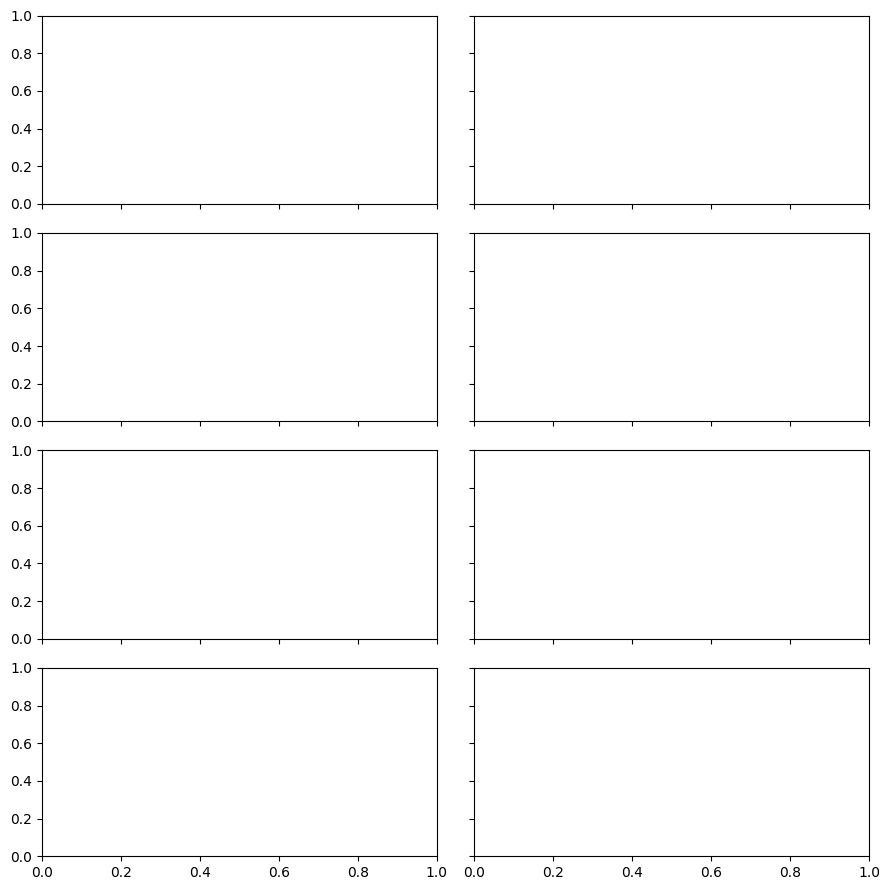

In [15]:
fig,ax = plt.subplots(4,2,tight_layout=True,figsize=(9,9),sharey=True,sharex=True)
# print("OffsetX,OffsetY,Theta,Phi,dQdx_sim/dQdx_exp,Q_ADC/Q_full")
linestyles = ["-","--",":","dashdot"]
for i in tqdm(range(tracks.shape[0])):
    j = i % 16
    if i // 16 != 1:
        continue
    ax_x = j % 4
    ax_y = 0
    
    selected_tracks = tracks[i:i+1]
    TPB = 256
    BPG = ceil(selected_tracks.shape[0] / TPB)

    quenching.quench[BPG,TPB](selected_tracks, consts.birks)
    drifting.drift[BPG,TPB](selected_tracks)

    # Here we build a map between tracks and event IDs
    unique_eventIDs = np.unique(selected_tracks['eventID'])
    event_id_map = np.searchsorted(unique_eventIDs,selected_tracks['eventID'])

    longest_pix = ceil(max(selected_tracks["dx"])/consts.pixel_pitch)
    max_radius = ceil(max(selected_tracks["tran_diff"])*5/consts.pixel_pitch)

    MAX_PIXELS = int((longest_pix*4+6)*max_radius*1.5)
    MAX_ACTIVE_PIXELS = int(longest_pix*1.5)

    active_pixels = np.full((selected_tracks.shape[0], MAX_ACTIVE_PIXELS, 2), -1, dtype=np.int32)
    neighboring_pixels = np.full((selected_tracks.shape[0], MAX_PIXELS, 2), -1, dtype=np.int32)
    n_pixels_list = np.zeros(shape=(selected_tracks.shape[0]))
    TPB = 128
    BPG = ceil(selected_tracks.shape[0] / TPB)
    pixels_from_track.get_pixels[BPG,TPB](selected_tracks,
                                          active_pixels,
                                          neighboring_pixels,
                                          n_pixels_list,
                                          max_radius+1)
    
    shapes = neighboring_pixels.shape
    joined = neighboring_pixels.reshape(shapes[0]*shapes[1],2)
    unique_pix = np.unique(joined,axis=0)
    unique_pix = unique_pix[(unique_pix[:,0] != -1) & (unique_pix[:,1] != -1),:]
    
    max_length = cp.array([0])
    track_starts = cp.empty(selected_tracks.shape[0])
    threadsperblock = 128
    blockspergrid = ceil(selected_tracks.shape[0] / threadsperblock)
    detsim.time_intervals[blockspergrid,threadsperblock](track_starts, max_length,  event_id_map, selected_tracks)
    
    signals = cp.zeros((selected_tracks.shape[0],
                        neighboring_pixels.shape[1],
                        cp.asnumpy(max_length)[0]), dtype=np.float32)
    threadsperblock = (1,1,64)
    blockspergrid_x = ceil(signals.shape[0] / threadsperblock[0])
    blockspergrid_y = ceil(signals.shape[1] / threadsperblock[1])
    blockspergrid_z = ceil(signals.shape[2] / threadsperblock[2])
    blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)
    detsim.tracks_current[blockspergrid,threadsperblock](signals,
                                                         neighboring_pixels,
                                                         selected_tracks)
    
    pixel_index_map = np.full((selected_tracks.shape[0], neighboring_pixels.shape[1]), -1)
    compare = neighboring_pixels[..., np.newaxis, :] == unique_pix
    indices = np.where(np.logical_and(compare[..., 0], compare[..., 1]))

    pixel_index_map[indices[0], indices[1]] = indices[2]

    blockspergrid_x = ceil(signals.shape[0] / threadsperblock[0])
    blockspergrid_y = ceil(signals.shape[1] / threadsperblock[1])
    blockspergrid_z = ceil(signals.shape[2] / threadsperblock[2])
    blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)
    pixels_signals = np.zeros((len(unique_pix), len(consts.time_ticks)))
    detsim.sum_pixel_signals[blockspergrid,threadsperblock](pixels_signals,
                                                            signals,
                                                            track_starts,
                                                            pixel_index_map)

    my_pix = np.where((unique_pix[:,0]==11) & (unique_pix[:,1] == 11))[0][0]

    my_signal = pixels_signals[my_pix]
    integral = np.cumsum(my_signal) * consts.t_sampling
    ratio_measured = integral[-1]/lengths[i]
    ratio_expected = consts.MeVToElectrons * consts.e_charge * 2

    time_ticks = cp.linspace(0, consts.time_interval[1], pixels_signals.shape[1]+1)
    integral_list = cp.zeros((pixels_signals.shape[0], fee.MAX_ADC_VALUES))
    adc_ticks_list = cp.zeros((pixels_signals.shape[0], fee.MAX_ADC_VALUES))
    integrate = cp.zeros((pixels_signals.shape[0], consts.time_ticks.shape[0]))
    TPB = 128
    BPG = ceil(pixels_signals.shape[0] / TPB)

    rng_states = create_xoroshiro128p_states(TPB * BPG, seed=0)
    fee.get_adc_values[BPG,TPB](pixels_signals,
                                time_ticks,
                                integral_list,
                                adc_ticks_list,
                                0,
                                rng_states,
                                integrate)
    adc_list = fee.digitize(integral_list)
    my_adcs = adc_list[my_pix][adc_list[my_pix]>73]
    my_adcs_charge = sum((my_adcs/fee.ADC_COUNTS * (fee.V_REF-fee.V_CM) + fee.V_CM - fee.V_PEDESTAL)/fee.GAIN)*consts.e_charge

    ax[ax_x][ax_y].plot(consts.time_ticks,integrate[my_pix].get(),color='tab:orange',ls=linestyles[int(j//4)],
                        label=r'$\theta=%.2f^{\circ}$'% angles[j][0])#'~\mathrm{dQdx}_{\mathrm{sim}}/\mathrm{dQdx}_{\mathrm{exp}} = %.2f$' % (angles[j][0],ratio_measured/ratio_expected))
    ax[ax_x][ax_y].set_xlim(consts.time_ticks[np.nonzero(my_signal)[0][0]],consts.time_ticks[np.nonzero(my_signal)[0][-1]])
    ax[ax_x][ax_y].set_title(r"$\phi=%.2f^{\circ}$"%angles[j][1], fontdict={'fontsize': 8})
    if ax_x == 3:
        ax[ax_x][ax_y].set_xlabel(r"Time [$\mathrm{\mu}$s]")
    if ax_y == 0:
        ax[ax_x][ax_y].set_ylabel("Integrated charge [C]")
    ax[ax_x][ax_y].yaxis.get_offset_text().set_fontsize(8)

    ax[ax_x][ax_y].tick_params(axis='both', which='major', labelsize=8)
    ax[ax_x][ax_y].tick_params(axis='both', which='minor', labelsize=8)
    ax[ax_x][ax_y].axhline(fee.DISCRIMINATION_THRESHOLD,ls='--',c='gray',label='Discrimination threshold' if ax_x==3 and int(j//4)==3 else '')
    ax[ax_x][ax_y].legend(prop={'size': 6})


#     print(np.sum(integral_list),my_pix)
#     print(sum(integral_list[my_pix]),float(my_adcs_charge),float(integral[-1]))
#     print(i,float(my_adcs_charge)/float(integral[-1]))
#     print(adc_list)
#     print(offsets[i//16][0],",",
#           offsets[i//16][1],",",
#           angles[j][0],",",
#           angles[j][1],",",
#           ratio_measured/ratio_expected,",",
#           float(my_adcs_charge)/float(integral[-1]),sep="")
    
fig.savefig('waveforms.pdf')

### 3D event display

In [ ]:
cmap = cm.Spectral_r
norm = colors.Normalize(vmin=0, vmax=256)
m = cm.ScalarMappable(norm=norm, cmap=cmap)

cmap = cm.viridis
norm_curr = colors.LogNorm(vmin=min(currents[currents>0]), vmax=max(currents))
m_curr = cm.ScalarMappable(norm=norm_curr, cmap=cmap)
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

for it,t in enumerate(selected_tracks):
    if it == 0:
        ax.plot((t["x_start"], t["x_end"]), 
            (t["z_start"], t["z_end"]),
            (t["y_start"], t["y_end"]),
            c='r',
            lw=1,
            alpha=1,
            zorder=10,
            label='Geant4 detector segment')
    else:
        ax.plot((t["x_start"], t["x_end"]), 
                (t["z_start"], t["z_end"]),
                (t["y_start"], t["y_end"]),
                c='r',
                lw=1,
                alpha=1,
                zorder=9999)
        
    ax.plot((t["x_start"], t["x_end"]), 
            (consts.tpc_borders[t['pixel_plane']][2][0], consts.tpc_borders[t['pixel_plane']][2][0]),
            (t["y_start"], t["y_end"]),
            c='r',
            lw=1,
            ls=':',
            alpha=1,
            zorder=9999)
        
for ip, p in enumerate(unique_pix):
    x_rect, y_rect = detsim.get_pixel_coordinates(p.get())
    pixel_plane = int(p[0] // consts.n_pixels[0])
    row = int(pixel_plane // 4)
    column = int(pixel_plane % 4)
    if currents[ip] > 0:
        rect = plt.Rectangle((x_rect, y_rect),
                             consts.pixel_pitch, consts.pixel_pitch,
                             linewidth=0.1, fc=m_curr.to_rgba(currents[ip].get()),
                             edgecolor='gray')
        ax.add_patch(rect)
        art3d.pathpatch_2d_to_3d(rect, z=consts.tpc_borders[pixel_plane][2][0], zdir="y")


        
anode1 = plt.Rectangle((consts.tpc_borders[0][0][0], consts.tpc_borders[0][1][0]),
                        consts.tpc_borders[0][0][1]-consts.tpc_borders[0][0][0], 
                        consts.tpc_borders[0][1][1]-consts.tpc_borders[0][1][0],
                       linewidth=1, fc='none',
                       edgecolor='gray', label=('Pixel' if ip == 5 else ''))
ax.add_patch(anode1)
art3d.pathpatch_2d_to_3d(anode1, z=consts.tpc_borders[0][2][0], zdir="y")

anode2 = plt.Rectangle((consts.tpc_borders[0][0][0], consts.tpc_borders[0][1][0]),
                        consts.tpc_borders[0][0][1]-consts.tpc_borders[0][0][0], 
                        consts.tpc_borders[0][1][1]-consts.tpc_borders[0][1][0],
                       linewidth=1, fc='none',
                       edgecolor='gray', label=('Pixel' if ip == 5 else ''))
ax.add_patch(anode2)
art3d.pathpatch_2d_to_3d(anode2, z=consts.tpc_borders[1][2][0], zdir="y")

cathode = plt.Rectangle((consts.tpc_borders[0][0][0], consts.tpc_borders[0][1][0]),
                        consts.tpc_borders[0][0][1]-consts.tpc_borders[0][0][0], 
                        consts.tpc_borders[0][1][1]-consts.tpc_borders[0][1][0],
                        linewidth=1, fc='gray', alpha=0.5,
                        edgecolor='gray', label=('Pixel' if ip == 5 else ''))
ax.add_patch(cathode)
art3d.pathpatch_2d_to_3d(cathode, z=0, zdir="y")

ax.plot((consts.tpc_borders[0][0][0],consts.tpc_borders[0][0][0]),(consts.tpc_borders[0][2][0],consts.tpc_borders[1][2][0]),
        (consts.tpc_borders[0][1][0],consts.tpc_borders[0][1][0]), lw=1,color='gray')

ax.plot((consts.tpc_borders[0][0][0],consts.tpc_borders[0][0][0]),(consts.tpc_borders[0][2][0],consts.tpc_borders[1][2][0]),
        (consts.tpc_borders[0][1][1],consts.tpc_borders[0][1][1]), lw=1,color='gray')

ax.plot((consts.tpc_borders[0][0][1],consts.tpc_borders[0][0][1]),(consts.tpc_borders[0][2][0],consts.tpc_borders[1][2][0]),
        (consts.tpc_borders[0][1][0],consts.tpc_borders[0][1][0]), lw=1,color='gray')

ax.plot((consts.tpc_borders[0][0][1],consts.tpc_borders[0][0][1]),(consts.tpc_borders[0][2][0],consts.tpc_borders[1][2][0]),
        (consts.tpc_borders[0][1][1],consts.tpc_borders[0][1][1]), lw=1,color='gray')



# ax.set_ylim(consts.module_borders[pixel_plane][2][0],50)
ax.set_xlim(consts.tpc_borders[0][0][0],consts.tpc_borders[1][0][1])
ax.set_ylim(consts.tpc_borders[0][2][0],consts.tpc_borders[1][2][0])
ax.set_zlim(consts.tpc_borders[0][1][0],consts.tpc_borders[1][1][1])

ax.set_box_aspect((2,2,4))
ax.grid(False)
ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.yaxis.set_major_locator(plt.MaxNLocator(3))
# ax.set_axis_off()
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

ax.view_init(azim=20)
# def rotate(angle):
#     ax.view_init(azim=angle)
    
# from matplotlib import animation

# rot_animation = animation.FuncAnimation(fig, rotate, frames=np.arange(0,362,2),interval=50)

ax.set_ylabel("z [cm]")
ax.set_xlabel("x [cm]")
ax.set_zlabel("y [cm]")
_ = plt.colorbar(m_curr,fraction=0.035, pad=0.05,label='Induced current integral [# electrons]')


In [ ]:
# rot_animation.save('animation.gif', writer='imagemagick', fps=10, bitrate=10, dpi=100)

### Electronics response and digitization 
Here we simulate the electronics response (the self-triggering cycle) and the signal digitization.

### 2D event display with induced current and ADC counts

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(6,3.8))
importlib.reload(detsim)
for ip, p in enumerate(unique_pix):
    x_rect, y_rect = detsim.get_pixel_coordinates(p.get())
    pixel_plane = int(p[0] // consts.n_pixels[0])
    c = currents[ip].get()
    if c >= 1:    
        rect = plt.Rectangle((x_rect, y_rect),
                             consts.pixel_pitch, consts.pixel_pitch,
                             linewidth=0.2, fc=m_curr.to_rgba(c),
                             edgecolor='grey')
        ax[0].add_patch(rect)

    a = adc_list[ip][adc_list[ip]>fee.digitize(0)]
    if len(a):    
        rect = plt.Rectangle((x_rect, y_rect),
                             consts.pixel_pitch, consts.pixel_pitch,
                             linewidth=0.2, fc=m.to_rgba(np.sum(a.get())),
                             edgecolor='grey')
        ax[1].add_patch(rect)


for it,t in enumerate(selected_tracks):
    ax[0].plot((t["x_start"], t["x_end"]), 
            (t["y_start"], t["y_end"]),
            c='r',
            lw=1.25,
            ls=':',
            alpha=1,
            zorder=10)
    ax[1].plot((t["x_start"], t["x_end"]), 
            (t["y_start"], t["y_end"]),
            c='r',
            lw=0,
            ls=':',
            alpha=1,
            zorder=10)
    ax[0].scatter((t["x_start"], t["x_end"]), 
                  (t["y_start"], t["y_end"]),
                  c='r', s=1, zorder=99999)
#     ax[1].scatter((t["x_start"], t["x_end"]), 
#                   (t["y_start"], t["y_end"]),
#                   c='r', s=1, zorder=99999)       

ax[0].set_aspect("equal")
ax[1].set_aspect("equal")
ax[0].set_xlabel("x [cm]")
ax[1].set_xlabel("x [cm]")
ax[0].set_ylabel("y [cm]")
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

divider0 = make_axes_locatable(ax[1])
cax0 = divider0.append_axes("right", size="7%", pad=0.07)
fig.colorbar(m, ax=ax[1], cax=cax0, label='ADC counts sum')

divider1 = make_axes_locatable(ax[0])
cax1 = divider1.append_axes("right", size="7%", pad=0.07)
fig.colorbar(m_curr, ax=ax[0], cax=cax1, label='Induced current integral [# electrons]')

plt.subplots_adjust(hspace=0.5)
fig.savefig("currentadc.pdf")

### Export result
As a last step we backtrack the ADC counts to the Geant4 tracks and we export the result in a HDF5 file.

In [ ]:
MAX_TRACKS_PER_PIXEL = 5

# Mapping between unique pixel array and track array index
track_pixel_map = cp.full((unique_pix.shape[0], MAX_TRACKS_PER_PIXEL), -1)
TPB = 32
BPG = ceil(unique_pix.shape[0] / TPB)
detsim.get_track_pixel_map[BPG, TPB](track_pixel_map, unique_pix, neighboring_pixels)

# Here we backtrack the ADC counts to the Geant4 tracks
TPB = 128
BPG = ceil(adc_list.shape[0] / TPB)
backtracked_id = cp.full((adc_list.shape[0], adc_list.shape[1], MAX_TRACKS_PER_PIXEL), -1)

detsim.backtrack_adcs[BPG,TPB](selected_tracks,
                               adc_list,
                               adc_ticks_list,
                               track_pixel_map,
                               event_id_map,
                               unique_eventIDs,
                               backtracked_id,
                               0)

In [ ]:
!rm test.h5
pc = fee.export_to_hdf5(adc_list.get(),
                        adc_ticks_list.get(),
                        unique_pix.get(),
                        backtracked_id.get(),
                        "test.h5")